In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from time import time
from joblib import Parallel, delayed

from src.CP_VQA.Qiskit_CP_VQA import Qiskit_CP_VQA
#from src.CP_VQA.Qsim_CP_VQA import Qsim_CP_VQA
from src.CP_VQA.Qulacs_CP_VQA import Qulacs_CP_VQA
from src.CP_VQA.Spynoza_CP_VQA import Spynoza_CP_VQA

from src.Qubo import Qubo
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       qubo_limits, 
                       check_qubo)

In [3]:
def simulate(settings: dict):
    result = {'N':settings['N']}
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=settings['N'], seed=settings['seed'])
    # Retrieving C_min, C_max and corresponding states for original portfolio problem
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=settings['N'],
                                                                k=settings['k'],
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=settings['alpha'])

    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances, 
                         alpha=settings['alpha'],
                         lmbda=lmbda+1, # Adding small constant purposely
                         k=settings['k'])
    qubo = Qubo(Q=Q, offset=offset) 
    qubo.subspace_c_min, qubo.subspace_c_max = constrained_result['c_min'], constrained_result['c_max']
    qubo.subspace_x_min, qubo.subspace_x_max = constrained_result['s_min'], constrained_result['s_max']
    qubo.full_space_c_min, qubo.full_space_c_max = full_result['c_min'], full_result['c_max']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=settings['alpha'], k=settings['k'])
     
    
    """qsim = Qsim_CP_VQA(N_qubits=settings['N'],
                       cardinality=settings['k'],
                       layers=settings['L'],
                       topology=settings['topology'],
                       with_next_nearest_neighbors=settings['w_nnn'],
                       get_full_state_vector=False,
                       qubo=qubo)"""
    
    qulacs = Qulacs_CP_VQA(N_qubits=settings['N'],
                       cardinality=settings['k'],
                       layers=settings['L'],
                       topology=settings['topology'],
                       with_next_nearest_neighbors=settings['w_nnn'],
                       get_full_state_vector=False,
                       qubo=qubo)
     
    qiskit = Qiskit_CP_VQA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           topology=settings['topology'],
                           with_next_nearest_neighbors=settings['w_nnn'],
                           approximate_hamiltonian=True,
                           qubo=qubo)
     
    spynoza = Spynoza_CP_VQA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           topology=settings['topology'],
                           with_next_nearest_neighbors=settings['w_nnn'],
                           qubo=qubo) 
    
     # Generating initial guess for rotation angles
    np.random.seed(settings['seed'])
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = settings['L'] * len(settings['topology'].get_NNN_indices()) if settings['w_nnn'] else settings['L'] * len(settings['topology'].get_NN_indices())
    CPVQA_theta_i = np.random.uniform(theta_min, theta_max, N_angles)
    
    qiskit_start_time = time()
    qiskit_sim = sc.optimize.minimize(fun=qiskit.get_cost, 
                              x0=CPVQA_theta_i,
                              method=settings['opt_method'],
                              options={'disp': False, 
                                       'maxiter': settings['max_iter']})
    qiskit_stop_time = time()
    if qiskit_sim['nfev'] > 0:
        time_pr_iter = (qiskit_stop_time-qiskit_start_time) / qiskit_sim['nfev']
        result['qiskit'] = time_pr_iter
    

    """qsim_start_time = time()
    qsim_sim = sc.optimize.minimize(fun=qsim.get_cost, 
                              x0=CPVQA_theta_i,
                              method=settings['opt_method'],
                              options={'disp': False, 
                                       'maxiter': settings['max_iter']})
    qsim_stop_time = time()
    if qsim_sim['nfev'] > 0:
        time_pr_iter = (qsim_stop_time-qsim_start_time) / qsim_sim['nfev']
        result['qsim'] = time_pr_iter"""
         
    
    qulacs_start_time = time()
    qulacs_sim = sc.optimize.minimize(fun=qulacs.get_cost, 
                              x0=CPVQA_theta_i,
                              method=settings['opt_method'],
                              options={'disp': False, 
                                       'maxiter': settings['max_iter']})
    qulacs_stop_time = time()
    if qulacs_sim['nfev'] > 0:
        time_pr_iter = (qulacs_stop_time-qulacs_start_time) / qulacs_sim['nfev']
        result['qulacs'] = time_pr_iter
        
    
    spynoza_start_time = time()
    spynoza_sim = sc.optimize.minimize(fun=spynoza.get_cost, 
                              x0=CPVQA_theta_i,
                              method=settings['opt_method'],
                              options={'disp': False, 
                                       'maxiter': settings['max_iter']})
    spynoza_stop_time = time()
    if spynoza_sim['nfev'] > 0:
        time_pr_iter = (spynoza_stop_time-spynoza_start_time) / spynoza_sim['nfev']
        result['spynoza'] = time_pr_iter

    
    return  result

In [9]:
layer_dict = {2:1,  3:1,  4:1,
              5:2,  6:2,  7:3,
              8:5,  9:6,  10:6,
              11:5, 12:5, 13:5,
              14:5, 15:5, 16:5,
              17:6, 18:6, 19:6, 
              20:7, 21:7, 22:7}

max_iter = 10
alpha=0.5
N_seeds = 30
N_min, N_max = 2, 15
sim_settings = []
for seed in range(N_seeds):
    for N in range(N_min, N_max+1):
        topology = Chain(N_qubits=N)
        topology.set_initialization_strategy(strategy=np.array([0 if i%2 == 0 else 1 for i in range(N)]))
        setting = {'N'         :N,       'alpha'   :alpha,   'L'       :layer_dict[N], 
                   'seed'      :seed,    'topology':topology,'max_iter':max_iter,
                   'opt_method':'COBYLA','w_nnn'   :True,    'k'       :N//2}
        sim_settings.append(setting)

In [10]:
N_jobs=15
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(setting) for setting in sim_settings)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Batch computation too fast (0.06457185745239258s.) Setting batch_size=2.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]

In [11]:
qiskit_res  = {N: [] for N in range(N_min,N_max+1)}
qulacs_res  = {N: [] for N in range(N_min,N_max+1)}
qsim_res    = {N: [] for N in range(N_min,N_max+1)}
spynoza_res = {N: [] for N in range(N_min,N_max+1)}

for res in r: 
    if res['qiskit'] is not None:
        qiskit_res[res['N']].append(res['qiskit'])
    if res['qulacs'] is not None:
        qulacs_res[res['N']].append(res['qulacs'])
    """if res['qsim'] is not None:
        qsim_res[res['N']].append(res['qsim'])"""
    if res['spynoza'] is not None:
        spynoza_res[res['N']].append(res['spynoza'])

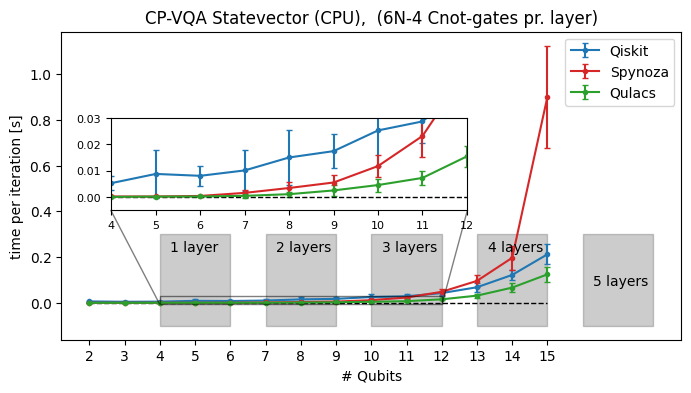

In [12]:
qiskit_avgs = np.array([[np.mean(qiskit_res[key]), np.std(qiskit_res[key])] for key in qiskit_res.keys()])
qsim_avgs = np.array([[np.mean(qsim_res[key]), np.std(qsim_res[key])] for key in qsim_res.keys()])
qulacs_avgs = np.array([[np.mean(qulacs_res[key]), np.std(qulacs_res[key])] for key in qulacs_res.keys()])
spynoza_avgs = np.array([[np.mean(spynoza_res[key]), np.std(spynoza_res[key])] for key in spynoza_res.keys()])

N_vals = [n for n in range(N_min, N_max+1)]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_title('CP-VQA Statevector (CPU),  (6N-4 Cnot-gates pr. layer)')

ax.errorbar(N_vals, qiskit_avgs[:,0], yerr=qiskit_avgs[:,1], fmt='.-', capsize=2, label='Qiskit', color='tab:blue')
#ax.errorbar(N_vals, qsim_avgs[:,0], yerr=qsim_avgs[:,1], fmt='.-', capsize=2, label='Qsim', color='tab:red')
ax.errorbar(N_vals, spynoza_avgs[:,0], yerr=spynoza_avgs[:,1], fmt='.-', capsize=2, label='Spynoza', color='tab:red')

ax.errorbar(N_vals, qulacs_avgs[:,0], yerr=qulacs_avgs[:,1], fmt='.-', capsize=2, label='Qulacs', color='tab:green')
ax.hlines(0, N_vals[0], N_vals[-1],ls='--',color='k', lw = 1)
ax.set_ylabel('time per iteration [s]')
ax.set_xlabel('# Qubits')
ax.set_xticks(N_vals)

ax.fill_between(np.linspace(4,6,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(4.3,0.225,'1 layer')

ax.fill_between(np.linspace(7,9,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(7.3,0.225,'2 layers')

ax.fill_between(np.linspace(10,12,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(10.3,0.225,'3 layers')

ax.fill_between(np.linspace(13,15,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(13.3,0.225,'4 layers')

ax.fill_between(np.linspace(16,18,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(16.3,0.075,'5 layers')

"""ax.fill_between(np.linspace(19,21,100), -np.ones(100)*0.1, np.ones(100)*2.5, alpha=0.2, color='k')
ax.text(19.5,2,'6 layers')"""

################## miniplot ##################
# inset axes....
axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.08, 0.42, 0.575, 0.3
axins = ax.inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])
axins.errorbar(N_vals, qiskit_avgs[:,0], yerr=qiskit_avgs[:,1], fmt='.-', capsize=2, label='Qiskit', color='tab:blue')
#axins.errorbar(N_vals, qsim_avgs[:,0], yerr=qsim_avgs[:,1], fmt='.-', capsize=2, label='Qsim', color='tab:red')
axins.errorbar(N_vals, spynoza_avgs[:,0], yerr=spynoza_avgs[:,1], fmt='.-', capsize=2, label='Spynoza', color='tab:red')

axins.errorbar(N_vals, qulacs_avgs[:,0], yerr=qulacs_avgs[:,1], fmt='.-', capsize=2, label='Qulacs', color='tab:green')
axins.hlines(0, N_vals[0], N_vals[-1],ls='--',color='k', lw = 1)

axins.set_xticks([4,5,6,7,8,9,10,11,12])
#axins.set_yticks([])
# sub region of the original image
x1, x2, y1, y2 = 3.99, 12.01, -0.005, 0.03
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(axis='both', which='major', labelsize=8)
ax.indicate_inset_zoom(axins, edgecolor="black")



ax.legend()
#plt.savefig('simulator_comparison_3.png', dpi=400)